In [6]:
# Import the pandas library.
import pandas
# Read in the airports data.
airports = pandas.read_csv("airports.csv", header=None, dtype=str)
airports.columns = ["id", "name", "city", "country", "code", "icao", "latitude", "longitude", "altitude", "offset", "dst", "timezone"]
# Read in the airlines data.
airlines = pandas.read_csv("airlines.csv", header=None, dtype=str)
airlines.columns = ["id", "name", "alias", "iata", "icao", "callsign", "country", "active"]
# Read in the routes data.
routes = pandas.read_csv("routes.csv", header=None, dtype=str)
routes.columns = ["airline", "airline_id", "source", "source_id", "dest", "dest_id", "codeshare", "stops", "equipment"]

In [7]:
airports.head()

,id,name,city,country,code,icao,latitude,longitude,altitude,offset,dst,timezone
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081689835,145.3919983,5282,10,U,Pacific/Port_Moresby
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207079887,145.7890015,20,10,U,Pacific/Port_Moresby
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826789856,144.2960052,5388,10,U,Pacific/Port_Moresby
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380356,147.2200012,146,10,U,Pacific/Port_Moresby


In [8]:
airlines.head()

,id,name,alias,iata,icao,callsign,country,active
0,-1,Unknown,\N,-,NaN,\N,\N,Y
1,1,Private flight,\N,-,NaN,NaN,NaN,Y
2,2,135 Airways,\N,NaN,GNL,GENERAL,United States,N
3,3,1Time Airline,\N,1T,RNX,NEXTIME,South Africa,Y
4,4,2 Sqn No 1 Elementary Flying Training School,\N,NaN,WYT,NaN,United Kingdom,N


In [9]:
routes.head()

,airline,airline_id,source,source_id,dest,dest_id,codeshare,stops,equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


In [10]:
routes = routes[routes["airline_id"] != "\\N"]

In [11]:
import math
def haversine(lon1, lat1, lon2, lat2):
    # Convert coordinates to floats.
    lon1, lat1, lon2, lat2 = [float(lon1), float(lat1), float(lon2), float(lat2)]
    # Convert to radians from degrees.
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    # Compute distance.
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    km = 6367 * c
    return km

In [12]:
def calc_dist(row):
    dist = 0
    try:
        # Match source and destination to get coordinates.
        source = airports[airports["id"] == row["source_id"]].iloc[0]
        dest = airports[airports["id"] == row["dest_id"]].iloc[0]
        # Use coordinates to compute distance.
        dist = haversine(dest["longitude"], dest["latitude"], source["longitude"], source["latitude"])
    except (ValueError, IndexError):
        pass
    return dist

In [13]:
route_lengths = routes.apply(calc_dist, axis=1)

(array([2.2631e+04, 1.9856e+04, 1.0061e+04, 5.3400e+03, 2.6230e+03,
        1.1050e+03, 8.7800e+02, 1.0370e+03, 9.2600e+02, 7.8200e+02,
        6.5500e+02, 5.5500e+02, 2.4900e+02, 2.4400e+02, 1.5400e+02,
        4.4000e+01, 3.8000e+01, 2.0000e+00, 0.0000e+00, 4.0000e+00]),
 array([    0.        ,   803.60790188,  1607.21580375,  2410.82370563,
         3214.43160751,  4018.03950938,  4821.64741126,  5625.25531313,
         6428.86321501,  7232.47111689,  8036.07901876,  8839.68692064,
         9643.29482252, 10446.90272439, 11250.51062627, 12054.11852815,
        12857.72643002, 13661.3343319 , 14464.94223378, 15268.55013565,
        16072.15803753]),
 <BarContainer object of 20 artists>)

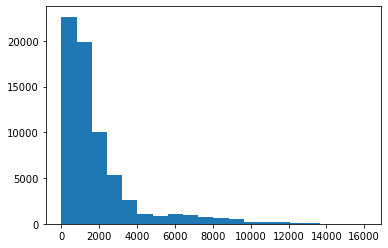

In [14]:
import matplotlib.pyplot as plt

plt.hist(route_lengths, bins=20)

D:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

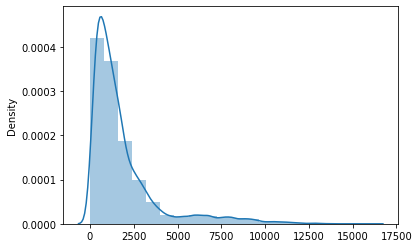

In [15]:
import seaborn
seaborn.distplot(route_lengths, bins=20)

In [17]:
import numpy
# Put relevant columns into a dataframe.
route_length_df = pandas.DataFrame({"length": route_lengths, "id": routes["airline_id"]})
# Compute the mean route length per airline.
airline_route_lengths = route_length_df.groupby("id").aggregate(numpy.mean)
# Sort by length so we can make a better chart.
airline_route_lengths = airline_route_lengths.sort_values("length", ascending=False)

<BarContainer object of 547 artists>

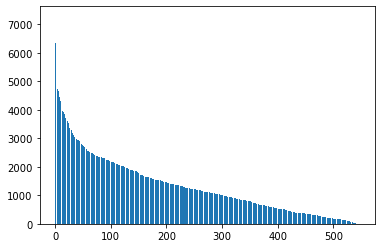

In [18]:
plt.bar(range(airline_route_lengths.shape[0]), airline_route_lengths["length"])

In [19]:
def lookup_name(row):
    try:
        # Match the row id to the id in the airlines dataframe so we can get the name.
        name = airlines["name"][airlines["id"] == row["id"]].iloc[0]
    except (ValueError, IndexError):
        name = ""
    return name
# Add the index (the airline ids) as a column.
airline_route_lengths["id"] = airline_route_lengths.index.copy()
# Find all the airline names.
airline_route_lengths["name"] = airline_route_lengths.apply(lookup_name, axis=1)
# Remove duplicate values in the index.
airline_route_lengths.index = range(airline_route_lengths.shape[0])

In [33]:
import numpy as np
from bokeh.io import output_notebook
#from bokeh.charts import Bar, showoutput_notebook()
#p = Bar(airline_route_lengths, 'name', values='length', title="Average airline route lengths")
#show(p)
from bokeh.plotting import figure
#p = figure(x_range=airline_route_lengths, height=250, title="Average airline route lengths", toolbar_location=None, tools="")

#p.vbar(x=airline_route_lengths, top=counts, width=0.9)

In [34]:
long_routes = len([k for k in route_lengths if k > 10000]) / len(route_lengths)
medium_routes = len([k for k in route_lengths if k < 10000 and k > 2000]) / len(route_lengths)
short_routes = len([k for k in route_lengths if k < 2000]) / len(route_lengths)

In [36]:
pip install pygal

Note: you may need to restart the kernel to use updated packages.


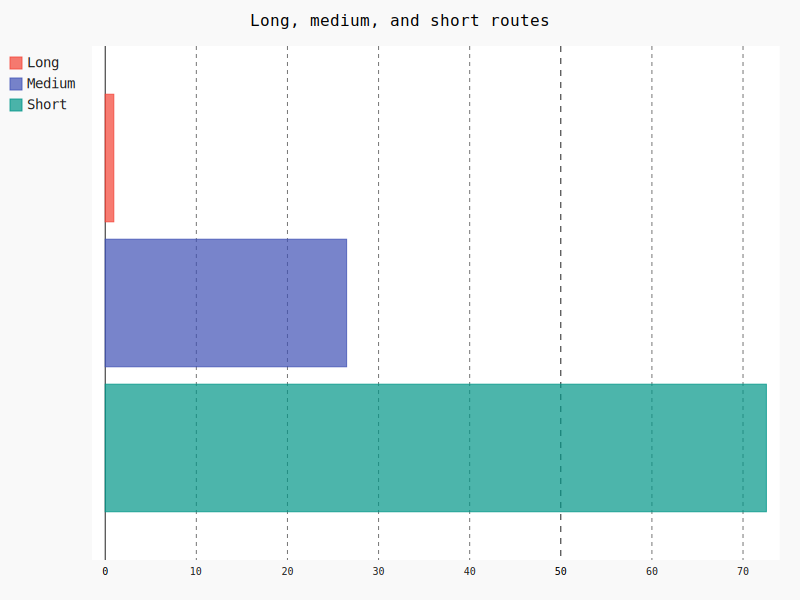

In [37]:
import pygal
from IPython.display import SVG
chart = pygal.HorizontalBar()
chart.title = 'Long, medium, and short routes'
chart.add('Long', long_routes * 100)
chart.add('Medium', medium_routes * 100)
chart.add('Short', short_routes * 100)
chart.render_to_file('routes.svg')
SVG(filename='routes.svg')

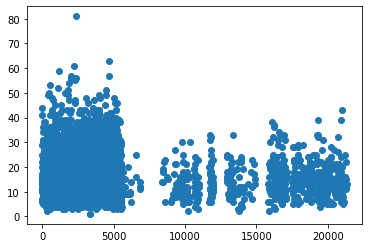

In [38]:
name_lengths = airlines["name"].apply(lambda x: len(str(x)))
plt.scatter(airlines["id"].astype(int), name_lengths)

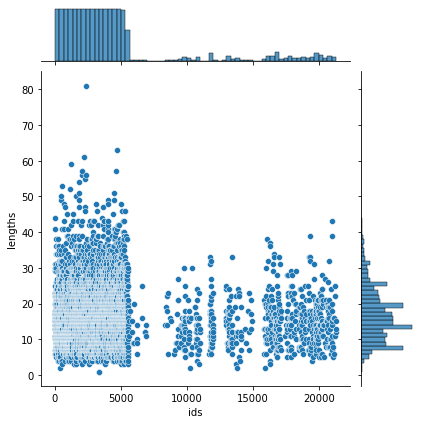

In [39]:
data = pandas.DataFrame({"lengths": name_lengths, "ids": airlines["id"].astype(int)})
seaborn.jointplot(x="ids", y="lengths", data=data)

In [41]:
pip install https://github.com/matplotlib/basemap/archive/master.zip

    ERROR: Command errored out with exit status 1:
     command: 'D:\Anaconda\python.exe' -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\aryam\\AppData\\Local\\Temp\\pip-req-build-xroz6nr1\\setup.py'"'"'; __file__='"'"'C:\\Users\\aryam\\AppData\\Local\\Temp\\pip-req-build-xroz6nr1\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\aryam\AppData\Local\Temp\pip-pip-egg-info-8epo4w6o'
         cwd: C:\Users\aryam\AppData\Local\Temp\pip-req-build-xroz6nr1\
    Complete output (18 lines):
    checking for GEOS lib in C:\Users\aryam ....
    checking for GEOS lib in C:\Users\aryam\local ....
    checking for GEOS lib in /usr ....
    checking for GEOS lib in /usr/local ....
    checking for GEOS lib in /sw ....
    checking for GEOS lib in /opt ....
    checking for GEOS lib in /opt/local ....
    
    Can't find geos 

    where geos is installed (for example, if geos_c.h
    is in /usr/local/include, and libgeos_c is in /usr/local/lib,
    set GEOS_DIR to /usr/local), or edit the setup.py script
    manually and set the variable GEOS_dir (right after the line
    that says "set GEOS_dir manually here".
    ----------------------------------------
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.


In [42]:
# Import the basemap package
from mpl_toolkits.basemap import Basemap
# Create a map on which to draw.  We're using a mercator projection, and showing the whole world.
m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
# Draw coastlines, and the edges of the map.
m.drawcoastlines()
m.drawmapboundary()
# Convert latitude and longitude to x and y coordinatesx, y = m(list(airports["longitude"].astype(float)), list(airports["latitude"].astype(float)))
# Use matplotlib to draw the points onto the map.
m.scatter(x,y,1,marker='o',color='red')
# Show the plot.
plt.show()

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [43]:
import folium
# Get a basic world map.
airports_map = folium.Map(location=[30, 0], zoom_start=2)
# Draw markers on the map.
for name, row in airports.iterrows():
    # For some reason, this one airport causes issues with the map.
    if row["name"] != "South Pole Station":
        airports_map.circle_marker(location=[row["latitude"], row["longitude"]], popup=row["name"])
# Create and show the map.airports_map.create_map('airports.html')
airports_map

ModuleNotFoundError: No module named 'folium'

In [44]:
# Make a base map with a mercator projection.
# Draw the coastlines.
m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
m.drawcoastlines()
# Iterate through the first 3000 rows.
for name, row in routes[:3000].iterrows():
    try:
        # Get the source and dest airports.
        source = airports[airports["id"] == row["source_id"]].iloc[0]
        dest = airports[airports["id"] == row["dest_id"]].iloc[0]
        # Don't draw overly long routes.
        if abs(float(source["longitude"]) - float(dest["longitude"])) < 90:
            # Draw a great circle between source and dest airports.
            m.drawgreatcircle(float(source["longitude"]), float(source["latitude"]), float(dest["longitude"]), float(dest["latitude"]),linewidth=1,color='b')
    except (ValueError, IndexError):
        pass
    # Show the map.
plt.show()

NameError: name 'Basemap' is not defined

In [45]:
# Initialize the weights dictionary.
weights = {}
# Keep track of keys that have been added once -- we only want edges with a weight of more than 1 to keep our network size manageable.added_keys = []
# Iterate through each route.
for name, row in routes.iterrows():
    # Extract the source and dest airport ids.
    source = row["source_id"]
    dest = row["dest_id"]
        # Create a key for the weights dictionary.
    # This corresponds to one edge, and has the start and end of the route.
    key = "{0}_{1}".format(source, dest)
    # If the key is already in weights, increment the weight.
    if key in weights:
        weights[key] += 1
    # If the key is in added keys, initialize the key in the weights dictionary, with a weight of 2.
    elif key in added_keys:
        weights[key] = 2
    # If the key isn't in added_keys yet, append it.
    # This ensures that we aren't adding edges with a weight of 1.
    else:
        added_keys.append(key)

NameError: name 'added_keys' is not defined

In [46]:
# Import networkx and initialize the graph.
import networkx as nx
graph = nx.Graph()
# Keep track of added nodes in this set so we don't add twice.
nodes = set()
# Iterate through each edge.
for k, weight in weights.items():
    try:
        # Split the source and dest ids and convert to integers.
        source, dest = k.split("_")
        source, dest = [int(source), int(dest)]
        # Add the source if it isn't in the nodes.
        if source not in nodes:
            graph.add_node(source)
        # Add the dest if it isn't in the nodes.
        if dest not in nodes:
            graph.add_node(dest)
        # Add both source and dest to the nodes set.
        # Sets don't allow duplicates.
        nodes.add(source)
        nodes.add(dest)
                # Add the edge to the graph.
        graph.add_edge(source, dest, weight=weight)
    except (ValueError, IndexError):
        passpos=nx.spring_layout(graph)
# Draw the nodes and edges.nx.draw_networkx_nodes(graph,pos, node_color='red', node_size=10, alpha=0.8)
nx.draw_networkx_edges(graph,pos,width=1.0,alpha=1)
# Show the plot.
plt.show()

NameError: name 'pos' is not defined